In [1]:
## import mods
import pandas as pd, numpy as np, scipy.stats as ss, seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
plt.style.use(['tableau-colorblind10'])

In [3]:
def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [4]:
## Bring in genotype data
geno_path = '~/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
geno_df = pd.read_csv(geno_path)
loci = geno_df.Block.drop_duplicates().index

In [53]:
## Define chromosomes
chrlist = sorted(geno_df.Chrom.unique())
print(chrlist)

['Chr01', 'Chr02', 'Chr03', 'Chr04', 'Chr05', 'Chr06', 'Chr07', 'Chr08', 'Chr09', 'Chr10', 'Chr11', 'Chr12', 'Chr13', 'Chr14']


In [55]:
## Gather the length of each chromosome
clens = [geno_df[(geno_df.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]

In [56]:
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [6]:
file_path = '/home/croth/Downloads/scores.csv'
file_path_tecan ='/home/croth/Desktop/Tecan_qtlruns_Jan162019_curated_baselined_median51.csv'

In [7]:
tecan  = pd.read_csv(file_path_tecan,index_col=0)

In [8]:
name_df = tecan[['row','column','plate','strain']].drop_duplicates().copy()

In [9]:
name_df.head()

,row,column,plate,strain
0,e,7,2,SS-A837
4,b,2,2,SS-B307
8,b,3,2,SS-B308
12,b,4,2,SS-B310
16,b,5,2,SS-B311


In [10]:
df = pd.read_csv(file_path)
#df.drop(df[(df.strain=='blank')].index,axis=0,inplace=True)

In [11]:
df.dropna(axis=1,how='all',inplace=True)

In [12]:
df.shape

(1152, 5)

In [13]:
df.Plate.unique()

array(['qtl1a', 'qtl1b', 'qtl1c', 'qtl1d', 'qtl2a', 'qtl2b', 'qtl2c',
       'qtl2d', 'qtl1a old', 'qtl1b old', 'qtl2a old', 'qtl2b old'],
      dtype=object)

In [14]:
df['row'] = df['Row']
df['column'] = df['Column']
df['plate'] = [ int(a.split('qtl')[-1][0]) for a in df.Plate]

In [15]:
df['Isold'] = [1 if 'old' in a else 0 for a in df.Plate.tolist()]

In [16]:
h2O2 = name_df.merge(df)

In [17]:
h2O2lh = h2O2[['Row','Column','Plate','ScoreLH','strain','Isold']].copy()
h2O2lh.columns = ['Row','Col','Plate','Score','Strain','Isold']
h2O2lh['Marker'] = 'LH'

In [18]:
h2O2dm = h2O2[['Row','Column','Plate','ScoreDM','strain','Isold']].copy()
h2O2dm.columns = ['Row','Col','Plate','Score','Strain','Isold']
h2O2dm['Marker'] = 'DM'

In [19]:
dmm = h2O2dm.dropna().groupby('Strain').agg(np.median).Score
lhm = h2O2lh.dropna().groupby('Strain').agg(np.median).Score

In [20]:
dmm_no = h2O2dm[(h2O2dm.Isold==0)].dropna().groupby('Strain').agg(np.median).Score
lhm_no = h2O2lh[(h2O2lh.Isold==0)].dropna().groupby('Strain').agg(np.median).Score

In [21]:
jitter = np.random.normal(0,0.1,len(dmm))

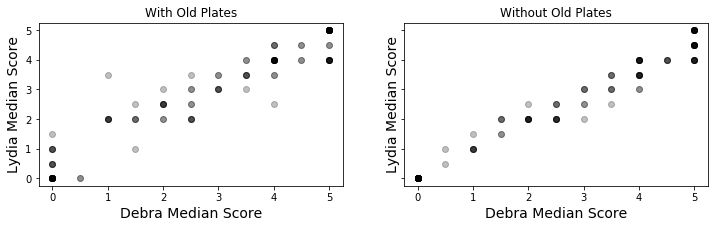

In [22]:
fig,ax = plt.subplots(1,2,figsize=(12,3),sharex=True,sharey=True)
plt.sca(ax[0])
plt.plot(dmm.values,
         lhm.values,'ko',alpha=0.25);
plt.xlabel('Debra Median Score',fontsize=14);
plt.ylabel('Lydia Median Score',fontsize=14);
plt.title('With Old Plates')

plt.sca(ax[1])
plt.title('Without Old Plates')
plt.plot(dmm_no.values,
         lhm_no.values,'ko',alpha=0.25);
plt.xlabel('Debra Median Score',fontsize=14);
plt.ylabel('Lydia Median Score',fontsize=14);
plt.savefig('/home/croth/Desktop/H2O2_median_growth_Debra_vs_Lydia_old_new.png',
           dpi=100,bbox_inches='tight');

In [23]:
np.corrcoef(dmm.values,lhm.values)[0][-1]

0.9554070913767132

In [24]:
np.corrcoef(dmm_no.values,lhm_no.values)[0][-1]

0.9843668610042586

In [25]:
#h2O2L = pd.concat([h2O2dm,h2O2lh],axis=0,sort=True)
h2O2L = pd.concat([h2O2dm[(h2O2dm.Isold==0)],
                   h2O2lh[(h2O2lh.Isold==0)]],axis=0,sort=True)

In [26]:
h2O2L.dropna(inplace=True)

In [27]:
h2O2Ls = h2O2L[(h2O2L.Strain.isin(geno_df.columns))]

In [28]:
segs = [a[0] for a in h2O2Ls.groupby('Strain')]

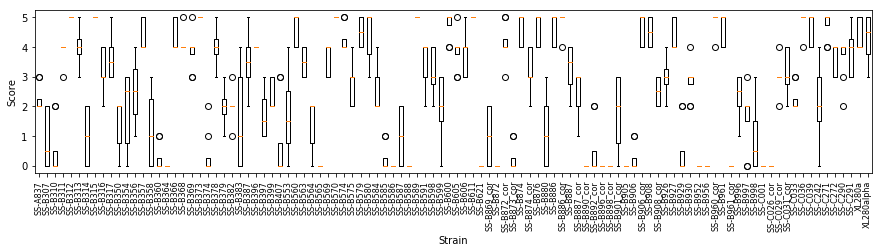

In [29]:
fig,ax = plt.subplots(1,1,figsize=(15,3))
plt.boxplot([a[1]['Score'].values 
             for a in h2O2Ls.groupby('Strain')]);

plt.xticks(np.arange(len(segs))+1,segs
           ,rotation=90,fontsize=8);
plt.xlabel('Strain');plt.ylabel('Score');

In [30]:
medh2o2 = h2O2Ls.groupby('Strain').agg(np.median)

In [31]:
medh2o2.head()

,Col,Isold,Score
Strain,,,
SS-A837,7,0,2.0
SS-B307,2,0,0.5
SS-B310,4,0,0.0
SS-B311,5,0,4.0
SS-B312,6,0,5.0


In [32]:
medh2o2.T['SS-A837']

Col      7.0
Isold    0.0
Score    2.0
Name: SS-A837, dtype: float64

In [33]:
_431label = r'$431\mathrm{\alpha}$'
_xl280alabel='XL280'+r'$\bf{a}$'
_xl280alphlabel = r'XL280$\mathrm{\alpha}$'
alpha_label = r'$\mathrm{\alpha}$ = 0.05'

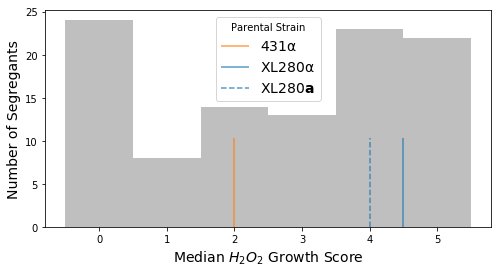

In [34]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
plt.hist(medh2o2.Score.values,color='grey',alpha=0.5,
         bins=np.arange(7)-0.5);
plt.xlabel('Median $H_{2}O_{2}$ Growth Score',fontsize=14);
plt.ylabel('Number of Segregants',fontsize=14);
plt.vlines(medh2o2.T['SS-A837'].T.Score,0,len(segs)/10,
           alpha=0.75,color='tab:orange',label=_431label);
plt.vlines(medh2o2.T['XL280alpha'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='-',
           color='tab:blue',label=_xl280alphlabel);
plt.vlines(medh2o2.T['XL280a'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='--',
           color='tab:blue',label=_xl280alabel);
plt.legend(title='Parental Strain',fontsize=14);
plt.savefig('/home/croth/Desktop/H2O2_median_growth_hist.png',
           dpi=100,bbox_inches='tight');

medh2o2p = medh2o2[['Score']].copy()
max_pvals = []

for i in range(1000):
    medh2o2p.index = np.random.permutation(medh2o2.index)
    
    maxpval = geno_df[segs].T[loci].T.apply(
        association_logPval,
        args=[medh2o2p.T[segs].T.Score],
        axis=1).max()
    
    max_pvals.append(maxpval)

threshold_95 = np.percentile(np.array(max_pvals),95)
threshold_99 = np.percentile(np.array(max_pvals),99)

In [35]:
medh2o2['Score_down'] = np.floor(medh2o2.Score.values)

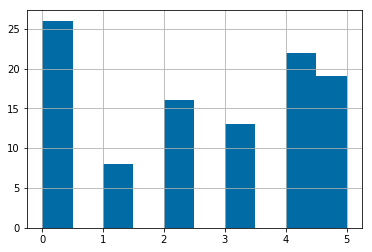

In [36]:
medh2o2.Score_down.hist();

In [39]:
len(segs)

104

In [40]:
test = geno_df[segs].drop_duplicates()
test.shape

(2777, 104)

In [41]:
test['Pval'] = test.apply(association_logPval,args=[medh2o2.T[segs].T.Score],axis=1)
pvaldf = geno_df.merge(test)

In [49]:
pvaldf[(pvaldf.Chrom=='Chr09')].Pval.max()

1.6155697532051163

In [44]:
pvaldf[(pvaldf.Chrom=='Chr12')].Pval.max()

4.518186729935608

In [46]:
sorted(pvaldf.Chrom.unique())

['Chr01',
 'Chr02',
 'Chr03',
 'Chr04',
 'Chr05',
 'Chr06',
 'Chr07',
 'Chr08',
 'Chr09',
 'Chr10',
 'Chr11',
 'Chr12',
 'Chr13',
 'Chr14']

In [47]:
cumpos

[0,
 2295469,
 3918491,
 6018867,
 7796806,
 9248631,
 10676347,
 12014832,
 13203967,
 14377580,
 15448500,
 16463227,
 17364860,
 18143261]

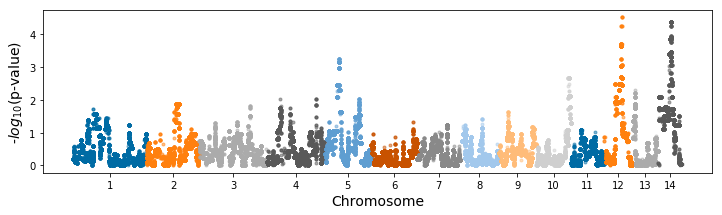

In [60]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(chrlist):
    #print(c,chrom)
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',alpha=0.5);

#plt.hlines(threshold_95,chrom_midpts[1],19*(10**6),
#           linestyle='--',alpha=0.7,
#           linewidth=1,label=alpha_label)

#plt.hlines(threshold_99,0,19*(10**6),
#           linestyle='-.',alpha=0.7,linewidth=1)

#plt.legend(bbox_to_anchor=(0.2,1.042),fontsize=14,frameon=False)
plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('-$log_{10}$(p-value)',fontsize=14);
#plt.ylim(-0.1,5);
#plt.savefig('/home/croth/Desktop/H2O2_QTL_wnp.png',
#            bbox_inches='tight',dpi=150);

In [61]:
ch02ix = pvaldf[(pvaldf.Chrom=='Chr02')].Pval.idxmax()

In [62]:
ch12ix = pvaldf[(pvaldf.Chrom=='Chr12')].Pval.idxmax()
ch14ix = pvaldf[(pvaldf.Chrom=='Chr14')].Pval.idxmax()

In [63]:
medh2o2['Chr02'] = np.array(pvaldf.T[ch02ix][segs],dtype=float)
medh2o2['Chr12'] = np.array(pvaldf.T[ch12ix][segs],dtype=float)
medh2o2['Chr14'] = np.array(pvaldf.T[ch14ix][segs],dtype=float)

In [64]:
medh2o2.head()

,Col,Isold,Score,Score_down,Chr02,Chr12,Chr14
Strain,,,,,,,
SS-A837,7,0,2.0,2.0,1.0,1.0,1.0
SS-B307,2,0,0.5,0.0,0.0,0.0,1.0
SS-B310,4,0,0.0,0.0,1.0,0.0,1.0
SS-B311,5,0,4.0,4.0,0.0,1.0,1.0
SS-B312,6,0,5.0,5.0,0.0,1.0,0.0


In [65]:
medh2o2.shape

(104, 7)

In [66]:
medh2o2.to_csv('/home/croth/H2O2_phenotypes.csv',index=True)

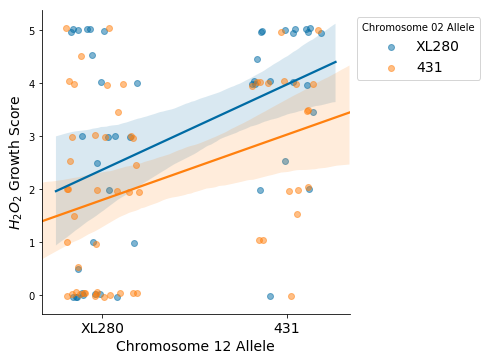

In [67]:
x = '12'
y = '02'
sns.lmplot(y='Score',x='Chr%s'%x,data=medh2o2,
           hue='Chr%s'%y, x_jitter=0.2,y_jitter=0.05,
           scatter_kws={'alpha':0.5},legend_out=False);
plt.xticks([0,1],labels=['XL280','431'],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);
plt.ylabel('$H_{2}O_{2}$ Growth Score',
           fontsize=14);

L=plt.legend(bbox_to_anchor=(1,1),
             title='Chromosome %s Allele'%y,
             fontsize=14)
L.get_texts()[0].set_text('XL280')
L.get_texts()[1].set_text('431')

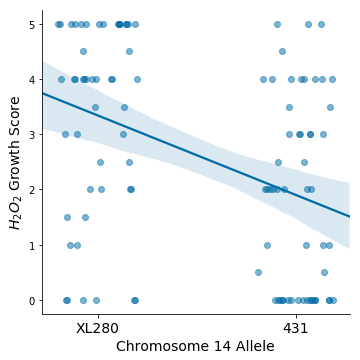

In [68]:
y = '12'
x = '14'
sns.lmplot(y='Score',x='Chr%s'%x,data=medh2o2,
          # hue='Chr%s'%y, 
           x_jitter=0.2,
           scatter_kws={'alpha':0.5},legend_out=False);
plt.xticks([0,1],labels=['XL280','431'],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);
plt.ylabel('$H_{2}O_{2}$ Growth Score',
           fontsize=14);

#L=plt.legend(bbox_to_anchor=(1,1),
      #       title='Chromosome %s Allele'%y,
      #       fontsize=14)
#L.get_texts()[0].set_text('XL280')
#L.get_texts()[1].set_text('431')

In [69]:
medh2o2.groupby(['Chr12','Chr14']).count()

Col  Isold  Score  Score_down  Chr02
Chr12 Chr14                                      
0.0   0.0     24     24     24          24     24
      1.0     41     41     41          41     41
1.0   0.0     26     26     26          26     26
      1.0     13     13     13          13     13

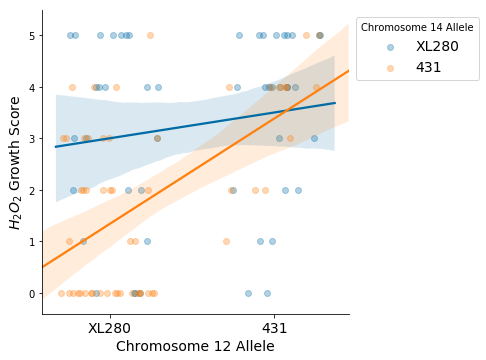

In [70]:
x = '12'
y = '14'
sns.lmplot(y='Score_down',x='Chr%s'%x,data=medh2o2,
           hue='Chr%s'%y,x_jitter=.3,
           scatter_kws={'alpha':0.30},
           legend_out=False);


#sns.swarmplot(y='Score',x='Chr%s'%x,data=medh2o2,
#           hue='Chr%s'%y,dodge=True)

L=plt.legend(bbox_to_anchor=(1,1),
             title='Chromosome %s Allele'%y,
             fontsize=14)

L.get_texts()[0].set_text('XL280')
L.get_texts()[1].set_text('431')

plt.xticks([0,1],labels=['XL280','431'],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);
plt.ylabel('$H_{2}O_{2}$ Growth Score',
           fontsize=14);
plt.savefig('/home/croth/Desktop/H2O2_Pheno_reg.png',
            dpi=150,bbox_inches='tight');

In [71]:
parents = medh2o2.T[['SS-A837','XL280a']].T[['Score','Chr02']]

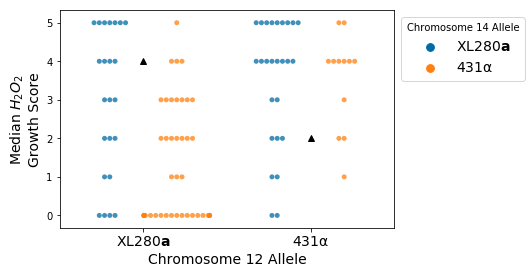

In [72]:
x = '12'
y = '14'

sns.swarmplot(y='Score_down',x='Chr%s'%x,
              data=medh2o2.T[[s for s in segs if s not in ['XL80a','XL280alpha','SS-A837']]].T,
           hue='Chr%s'%y,dodge=True,alpha=0.75)

L=plt.legend(bbox_to_anchor=(1,1),
             title='Chromosome %s Allele'%y,
             fontsize=14)

L.get_texts()[0].set_text(_xl280alabel)
L.get_texts()[1].set_text(_431label)

plt.xticks([0,1],labels=[_xl280alabel,_431label],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);

plt.plot(*parents.T.values[::-1],'k^')

plt.ylabel('Median $H_{2}O_{2}$\nGrowth Score',
           fontsize=14);
plt.savefig('/home/croth/Desktop/H2O2_Pheno_swarm.png',
            dpi=150,bbox_inches='tight');

In [73]:
from matplotlib.gridspec import GridSpec

In [74]:
from PIL import Image
plt.style.use(['tableau-colorblind10'])

In [75]:
import matplotlib.image as mpimg

In [76]:
medh2o2.head()

,Col,Isold,Score,Score_down,Chr02,Chr12,Chr14
Strain,,,,,,,
SS-A837,7,0,2.0,2.0,1.0,1.0,1.0
SS-B307,2,0,0.5,0.0,0.0,0.0,1.0
SS-B310,4,0,0.0,0.0,1.0,0.0,1.0
SS-B311,5,0,4.0,4.0,0.0,1.0,1.0
SS-B312,6,0,5.0,5.0,0.0,1.0,0.0


In [77]:
import statsmodels.formula.api as smf

(0.9355438351631165, 7.547019049525261e-05)


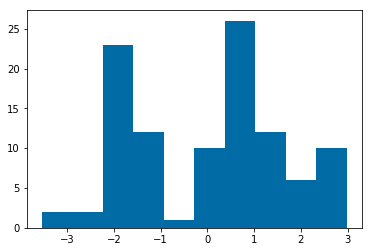

In [78]:
qtl12_res = smf.ols('Score~Chr12',data=medh2o2).fit()
print(ss.shapiro(qtl12_res.resid.values))
plt.hist(qtl12_res.resid.values);

(0.9372780919075012, 9.616556053515524e-05)


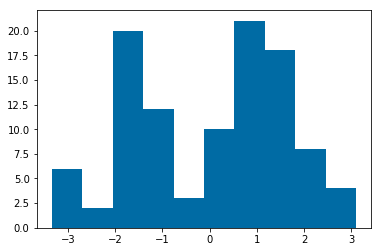

In [79]:
qtl14_res = smf.ols('Score~Chr14',data=medh2o2).fit()
print(ss.shapiro(qtl14_res.resid.values))
plt.hist(qtl14_res.resid.values);

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     12.85
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           3.62e-07
Time:                        13:57:10   Log-Likelihood:                -194.52
No. Observations:                 104   AIC:                             397.0
Df Residuals:                     100   BIC:                             407.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.0833      0.327      9.431      

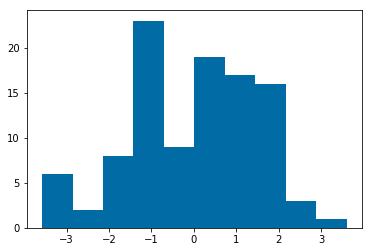

In [80]:
qtl12_14_res = smf.ols('Score~Chr12*Chr14',data=medh2o2).fit()
#print(ss.shapiro(qtl12_14_res.resid.values))
plt.hist(qtl12_14_res.resid.values);
print(qtl12_14_res.summary())

In [81]:
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [82]:
import os
kps = 10000
perms = []
perm_path = './Cden_H2O2_permutations.csv'
if not os.path.exists(perm_path):
    while len(perms)<kps:
    
        ran_pval = test[segs].apply(association_logPval,
                                args=[medh2o2.T[np.random.permutation(segs)].T.Score],
                                axis=1).max()
        perms.append(ran_pval)
    pd.DataFrame(perms,columns=['H2O2']).to_csv(perm_path,index=False)
else:
    perms = pd.read_csv(perm_path)['H2O2'].values
    
threshold_95 = np.percentile(perms,95)

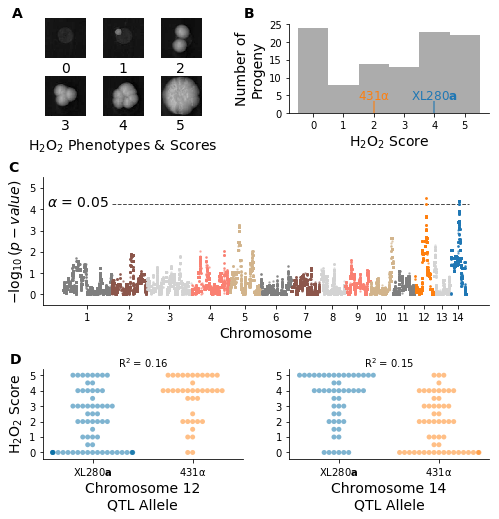

In [84]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(12,4,figure=fig)
ax_fake = fig.add_subplot(gs[:2,:2])
plt.sca(ax_fake)
[ax_fake.spines[s].set_visible(False) for s in ['top','right']]

plt.title(x=-0.125,y=1,label='A',
          fontsize=14,fontweight='bold')
plt.xticks([]);plt.yticks([])

[ax_fake.spines[j].set_visible(False) for j in ['top','bottom','left','right']]

ax_hist = fig.add_subplot(gs[:3,2:])

[ax_hist.spines[s].set_visible(False) for s in ['top','right']]


plt.hist(medh2o2.Score.values,color='grey',alpha=0.65,
         bins=np.arange(7)-0.5);

plt.xlabel('H$_{2}$O$_{2}$ Score',fontsize=14);
plt.xticks([0,1,2,3,4,5])
plt.ylabel('Number of\nProgeny',fontsize=14);
plt.yticks(np.arange(0,35,5))

plt.vlines(medh2o2.T['XL280a'].T.Score,0,3.5,
           alpha=0.75,linestyle='-',
           color='tab:blue')#,label=_xl280alabel);
plt.text(medh2o2.T['XL280a'].T.Score,4,
         _xl280alabel,fontsize=12,
         color='tab:blue',ha='center')

plt.vlines(medh2o2.T['SS-A837'].T.Score,0,3.5,
           alpha=0.75,color='tab:orange')#,label=_431label);
plt.text(medh2o2.T['SS-A837'].T.Score,4,
         _431label,fontsize=12,
         color='tab:orange',ha='center')

plt.title(x=-0.2,y=1,label='B',
          fontsize=14,fontweight='bold')

##### ----------------------------------------------------------###
ax_qtl1 = fig.add_subplot(gs[9:,:2])
[ax_qtl1.spines[s].set_visible(False) for s in ['top','right']]

sns.swarmplot(x='Chr12',y='Score',data=medh2o2,alpha=0.5)
plt.ylabel(r'H$_{2}$O$_{2}$ Score',fontsize=14)
plt.yticks(np.arange(6))
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 12\nQTL Allele',fontsize=14)
plt.title(x=-0.135,y=1,label='D',
          fontsize=14,fontweight='bold')
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl12_res.rsquared,2),
        ha='center')
### -------------------------------------------------------------- ###
ax_qtl2 = fig.add_subplot(gs[9:,2:])
[ax_qtl2.spines[s].set_visible(False) for s in ['top','right']]

sns.swarmplot(x='Chr14',y='Score',data=medh2o2,alpha=0.5)
plt.yticks(np.arange(6))
plt.ylabel('')
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 14\nQTL Allele',fontsize=14)
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl14_res.rsquared,2),
        ha='center')
### --------------------------- QTL MAPPING --------------------- ###

ax_qtl = fig.add_subplot(gs[4:8,:])

plt.sca(ax_qtl)
plt.title(x=-0.065,y=1,label='C',
          fontsize=14,fontweight='bold')

for c,chrom in enumerate(chrlist):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    
    if chrom == 'Chr12':
        cc = 'tab:orange'
    elif chrom == 'Chr14':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[c%len(chrom_colors)]

    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',alpha=0.5,color=cc,markersize=3);


plt.hlines(threshold_95,clens[0],19*(10**6),
           linestyle='--',alpha=0.7,
           linewidth=1,label=alpha_label)

#plt.legend(bbox_to_anchor=(0.231,.985),fontsize=14,frameon=False)
plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
#plt.ylabel('-log$_{10}$(p-value)',fontsize=14);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

plt.ylim(-0.5,5.5)
plt.yticks([0,1,2,3,4,5])
##### ------------------------------------------------------ #####
plt.sca(ax_hist)
yw = 0.07
yh = 0.82
yh2 = 0.72
ax0 = fig.add_axes([0.13,yh,yw,yw])
pheno0 = '/home/croth/H2O2_0_crop.png'
pheno0_obj = Image.open(pheno0)
plt.imshow(pheno0_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'0',va='center',ha='center',
         transform=ax0.transAxes,fontsize=14)
plt.axis('off')
#plt.title(x=-2,y=2.35,label='A',
#          fontsize=14,fontweight='bold')

ax1 = fig.add_axes([0.23,yh,yw,yw])
pheno1 = '/home/croth/H2O2_1_crop.png'
pheno1_obj = Image.open(pheno1)
plt.imshow(pheno1_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'1',va='center',ha='center',
         transform=ax1.transAxes,fontsize=14)
plt.axis('off')
plt.title(x=0.5,y=-2.4,
          label=r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',
         fontsize=14)
#plt.xlabel(r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',fontsize=14)


ax2 = fig.add_axes([0.33,yh,yw,yw])
pheno2 = '/home/croth/H2O2_2_crop.png'
pheno2_obj = Image.open(pheno2)
plt.imshow(pheno2_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'2',va='center',ha='center',
         transform=ax2.transAxes,fontsize=14)
plt.axis('off')


#ax3 = fig.add_axes([0.25,.7,0.09,0.09])
ax3 = fig.add_axes([0.13,yh2,yw,yw])
plt.sca(ax3)

pheno3 = '/home/croth/H2O2_3_crop.png'
pheno3_obj = Image.open(pheno3)
plt.imshow(pheno3_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'3',va='center',ha='center',
         transform=ax3.transAxes,fontsize=14)
plt.axis('off')


ax4 = fig.add_axes([0.23,yh2,yw,yw])
pheno4 = '/home/croth/H2O2_4_crop.png'
pheno4_obj = Image.open(pheno4)
plt.imshow(pheno4_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'4',va='center',ha='center',
         transform=ax4.transAxes,fontsize=14)
plt.axis('off')


n = 5
ax5 = fig.add_axes([0.33,yh2,yw,yw])
pheno5 = '/home/croth/H2O2_%s_crop.png'%n
pheno5_obj = Image.open(pheno5)
plt.imshow(pheno5_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'%s'%n,va='center',ha='center',
         transform=ax5.transAxes,fontsize=14)
plt.axis('off');


plt.sca(ax_qtl)
[ax_qtl.spines[s].set_visible(False) for s in ['top','right']]

plt.text(s = r'$\alpha$ = 0.05', x = 0.08,y= .8, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax_qtl.transAxes, fontsize=14 )

plt.subplots_adjust(hspace=2,wspace=.6)
plt.savefig('./C_deneoformans_H2O2_QTL.png',
            dpi=200,bbox_inches='tight');

In [ ]:
medh2o2.to_csv('~/H2O2_median_phenotypes.csv')

In [ ]:
medh2o2.head()

In [ ]:
threshold_95

In [ ]:
ric8 = np.array([386833, 389698])

In [ ]:
pvaldf[(pvaldf.Chrom=='Chr14') & 
       (pvaldf.Pval>=threshold_95)].Pos.min(),pvaldf[(pvaldf.Chrom=='Chr14') & 
                                                    (pvaldf.Pval>=threshold_95)].Pos.max()

C. deneoformans hydrogen peroxide (A) phenotypes and growth scores, (B) distribution of scores, (C) associated Manhattan plot, and (D) genotype by phenotype plots for detected QTLs on chromosome 2 and 14. 

In [ ]:
pvaldf.to_csv('/home/croth/H2O2_pvalues.csv',index=True)

In [ ]:
test.shape

In [ ]:
medh2o2.Score.mean()

In [ ]:
medh2o2.Score.var()

In [ ]:
mod = smf.ols('Score ~ Chr12*Chr14',data=medh2o2).fit()

In [ ]:
mod.summary()

In [ ]:
assert 1 == 0

In [ ]:
x = '12'
x = '14'
sns.lmplot(y='Score',x='Chr%s'%x,data=medh2o2,
           x_jitter=0.2,y_jitter=0.05,
           scatter_kws={'alpha':0.5},legend_out=False);
plt.xticks([0,1],labels=['XL280','431'],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);
plt.ylabel('$H_{2}O_{2}$ Growth Score',
           fontsize=14);

#L=plt.legend(bbox_to_anchor=(1,1),
#             title='Chromosome %s Allele'%y,
#             fontsize=14)
#L.get_texts()[0].set_text('XL280')
#L.get_texts()[1].set_text('431')

In [ ]:
x = '12'
sns.lmplot(y='Score',x='Chr%s'%x,data=medh2o2,
           x_jitter=0.2,y_jitter=0.05,
           scatter_kws={'alpha':0.5},legend_out=False);
plt.xticks([0,1],labels=['XL280','431'],fontsize=14)
plt.xlabel('Chromosome %s Allele'%x,
           fontsize=14);
plt.ylabel('$H_{2}O_{2}$ Growth Score',
           fontsize=14);

In [ ]:
assert 1 == 0

In [ ]:
## Bring in phenotype data
df = pd.read_csv(file_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
#df.index = df.strain
df = df[(df.strain.isin(geno_df.columns)) & (df.temp!=38)]
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))
df.head()

In [ ]:
nreps = df.groupby(['temp','amphB','strain']).count().reset_index()[
    ['temp','amphB','date']].groupby(['temp','amphB']).agg(np.median)
nreps

In [ ]:
segs = np.unique([s for s in df.strain if s in geno_df.columns])
strain_ix = geno_df.columns.tolist().index('Block') + 1
geno_strains = np.array(geno_df.columns.tolist()[strain_ix:])
X = geno_df.T[loci].T[segs].astype(float)

In [ ]:
strains_temp = pd.DataFrame(geno_strains).replace(dict(zip(['XL280a','XL280alpha'],['SS-B830','SS-A853'])))

cross_info = pd.read_csv('../../FILES/OLD/OCT2018/CDx_PB_Ill_Sample_Info.csv')

strain_out = cross_info[(cross_info.Strain.isin(strains_temp[0].tolist()))].copy()
sex = []
for i in strain_out.Code.tolist():
    if i == 1:
        sex.append('bi')
    elif i == 2:
        sex.append('un')
    else:
        sex.append('parent')
        pass
strain_out['Fasta'] = [a.split('-CR_')[0] for a in strain_out['PB-name']]
strain_out['Crosstype'] = sex
strain_out = strain_out[['Strain','Crosstype','Fasta']]
strain_out[(strain_out.Crosstype=='parent')]
strain_out.sort_values(['Strain']).to_csv('../../C_deneoformans_strain_info.csv',index=False);

In [ ]:
## Set precent of variance to explain
ps = .99

In [ ]:
## Gather unique temp and drug conditions
temps = df.temp.unique();print(temps)
drugs = df.amphB.unique();print(drugs)

In [ ]:
dfma = df[(df.strain.isin(segs)) & 
          (df.temp!=38)].groupby(['temp','amphB','strain'])[times_ixs].agg(np.median)

In [ ]:
assert dfma.shape[0] == len(segs) * len(temps) *len(drugs) - (len(segs))

In [ ]:
dfma.values.shape

In [ ]:
pca = PCA(ps)
principalComponents = pca.fit_transform(dfma)

In [ ]:
principalComponents.shape

In [ ]:
pca.components_.shape

In [ ]:
mc = dfma - dfma.mean()

In [ ]:
fig,ax = plt.subplots(1,pca.components_.shape[0],figsize=(10,3),sharex=True,sharey=True)
for i,c in enumerate(pca.components_):
    plt.sca(ax[i])
    plt.title(np.round(pca.explained_variance_ratio_[i],3)*100 )
    #if i == 0:
        #plt.plot(timex,c*15.0,'r')
    plt.plot(timex,dfma.mean(),'r')
    plt.plot(timex,dfma.mean()+c,'k')
    plt.plot(timex,dfma.mean()-c,'k--');

In [ ]:
pca_conditions = dfma.reset_index()[['temp','amphB','strain']]

In [ ]:
pca_temp = pd.DataFrame(principalComponents,columns=['PC1','PC2','PC3'])

In [ ]:
pca_by_con = pd.concat([pca_conditions,pca_temp],axis=1)

In [ ]:
pca_by_con.head()

In [ ]:
dfma.reset_index(inplace=True)

In [ ]:
dfma.head()

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(10,5),sharex=True,sharey=True);
for i,t in enumerate(temps):
    for j,d in enumerate(drugs):
        plt.sca(ax[i,j])
        plt.plot(pca_by_con[(pca_by_con.temp==t) & (pca_by_con.amphB==d)]['PC1'].values,
                 dfma[(dfma.temp==t) & (dfma.amphB==d)][times_ixs].sum(axis=1).values*dx,
                 'k.',alpha=0.5);
plt.sca(ax[0,0]);plt.ylabel('$AUC_{72}$',fontsize=14);
plt.sca(ax[-1,0]);plt.xlabel('PC1',fontsize=14);

In [ ]:
import seaborn as sns

In [ ]:
pca_by_con.temp.unique()

In [ ]:
pca_by_con['temp'] = pca_by_con['temp'].apply(int)

In [ ]:
my_colors= ['tab:blue','tab:red','tab:orange','tab:grey']

In [ ]:
var_explained = [np.round(a,1) for a in np.round(pca.explained_variance_ratio_,3)*100]

In [ ]:
np.sum(var_explained)

In [ ]:
var_explained

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(9,3),sharey=True,sharex=True)
plt.sca(ax[0])
plt.title("By Temperature\n")
means_temps = []
for i,t in enumerate(temps):
    temp = pca_by_con[(pca_by_con.temp==t)]
    plt.plot(temp.PC1,temp.PC2,'o',label=t,color=my_colors[i],alpha=0.35)
    means_temps.append((temp.PC1.mean(),temp.PC2.mean()))
plt.plot(*np.array(means_temps).T,'x--',ms=10,color='k',alpha=0.95);
plt.xlabel('PC1\n%s%s Variance Explained'%(var_explained[0],'%'),fontsize=14);
plt.ylabel('PC2\n%s%s Variance Explained'%(var_explained[1],'%'),fontsize=14);
plt.legend(title=u'°C',fontsize=14,bbox_to_anchor=(1,1.1))
plt.sca(ax[1])
plt.title('By Amphotericin B\nConcentration')
means_drugs = []
for i,d in enumerate(drugs):
    temp = pca_by_con[(pca_by_con.amphB==d)]
    plt.plot(temp.PC1,temp.PC2,'o',label=d,color=my_colors[i],alpha=0.35)
    means_drugs.append((temp.PC1.mean(),temp.PC2.mean()))
plt.plot(*np.array(means_drugs).T,'x--',ms=10,color='k',alpha=0.95);


plt.legend(title='\u03BCg / ml',fontsize=14,bbox_to_anchor=(.7,1.1))
for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
plt.xlim(principalComponents.T[0].min()-.5,principalComponents.T[0].max()+.5)
plt.ylim(principalComponents.T[0].min()-.5,principalComponents.T[0].max()+.5);
#plt.xlabel('PC1\n%s%s Variance Explained'%(var_explained[0],'%'),fontsize=14);
plt.xlabel('PC1',fontsize=14);
plt.subplots_adjust(wspace=0.08)
plt.savefig('./Cdx_functional_pca_tempxdurg.png',dpi=150,bbox_inches='tight');

In [ ]:
from statsmodels.multivariate.manova import MANOVA

In [ ]:
pca_by_con = pca_by_con.sort_values(['temp','amphB','strain'])

In [ ]:
pca_by_con.head()

In [ ]:
X.shape

In [ ]:
pctemp = pca_by_con[(pca_by_con.temp==37) & (pca_by_con.amphB==0.075)].copy()
pctemp.index= pctemp.strain

In [ ]:
pctemp.shape

In [ ]:
pc1_mw = []
pc = pctemp['PC3'].values
for i,j in X[pctemp.strain].iterrows():
    p0 = pc[(j.values==0)]
    p1 = pc[(j.values==1)]
    mann_pvalue = ss.mannwhitneyu(p0,p1).pvalue
    pc1_mw.append(-np.log10(mann_pvalue))

In [ ]:
pvaldf = geno_df.T[loci].T[['Pos','Chrom']]

In [ ]:
pvaldf['PC1_pval'] = pc1_mw

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,3),sharey=True)
for k, i in enumerate(pvaldf.columns[2:]):
    plt.sca(ax[k])
    for j, c in enumerate(chrlist):
        
        pt = pvaldf[(pvaldf.Chrom==c)]
        plt.plot( pt.Pos.values+cumpos[j], pt[i].values,'.',ms=2)

In [ ]:
def crypto_mann(x,y):
    
    p0 = y[(x==0)].values
    p1 = y[(x==1)].values
    ss.mannwhitneyu(p0,p1)

In [ ]:
xs = X.T.reset_index().copy()
xs.columns = ['strain'] + xs.columns[1:].tolist()

In [ ]:
pca_merg = pca_by_con.merge(xs)

In [ ]:
pca_merg[(pca_merg.strain=='SS-A837')][X.index].drop_duplicates().T.drop_duplicates().shape[0] == 1

In [ ]:
pca_col6 = pca_merg.columns.tolist()[:6]
pca_col7 = ['L%s'%c for c in pca_merg.columns.tolist()[6:]]
pca_merg.columns = pca_col6 + pca_col7

In [ ]:
pca_merg.head()

In [ ]:
geno_df[(geno_df.Block==533)].index[0]

In [ ]:
condf = pca_merg[['temp','amphB']].drop_duplicates()

In [ ]:
condf

In [ ]:
pvalues = [[MANOVA.from_formula('PC1 + PC2 + PC3 ~  %s'%k, data=pca_merg[(pca_merg.temp==j.temp) &
            (pca_merg.amphB==j.amphB)]).mv_test().results[k]['stat']['Pr > F'].values[0] 
         for k in pca_col7] 
        for i,j in condf.iterrows()]

pval_test = X.apply(association_logPval,args = [test_df.T[X.columns].T['PC1']],axis=1)

In [ ]:
len(pvalues)

In [ ]:
pvaldf = pd.DataFrame(-np.log10(np.array(pvalues))).T

In [ ]:
pvaldf.index = X.index

In [ ]:
pvaldf.head()

In [ ]:
pvaldf[['Pos','Chrom']] = geno_df[['Pos','Chrom']].T[X.index].T

In [ ]:
pvaldf.head()

In [ ]:
fig, ax= plt.subplots(3,4,figsize=(15,6),sharey=True)

for i, td in condf.iterrows():
    
    plt.sca(ax.ravel()[i])
    
    pval = pvaldf[[i]+['Pos','Chrom']]
    plt.xticks(chrom_midpts,np.arange(len(chrlist))+1,fontsize=6)
    for j, c in enumerate(chrlist):
        
        pt = pval[(pval.Chrom==c)]
        plt.plot( pt.Pos.values+cumpos[j], pt[i].values,'.',ms=2)
plt.subplots_adjust(wspace=0.091);
#plt.sca(ax[1,0]);plt.ylabel('$-log_{10} ( p-value )$',fontsize=14)
plt.sca(ax[-1,-1]);plt.axis('off');

for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title(u'Amphotericin B\n%s \u03BCg/ml'%(d) if i == 0 else u'%s \u03BCg/ml'%(d),fontsize=14)
    
for i,t in enumerate(temps):
    plt.sca(ax[i,0])
    plt.ylabel(u'Temperature\n%s \u00B0C\n\n$-log_{10} ( p-value )$'%(t) 
               if i == 1 else '\n%s \u00B0C\n\n'%(t),fontsize=14);
plt.subplots_adjust(wspace=0.05)
plt.sca(ax[-1,1]);plt.xlabel('Chromosomes',fontsize=14)
plt.savefig('/home/croth/Desktop/Cdx_PCA_QTL.png',dpi=100,bbox_inches='tight')

In [ ]:
8 /20

In [ ]:
temp_pca = pca_merg[(pca_merg.temp==30) & (pca_merg.amphB==0.0)].copy()

In [ ]:
strains = temp_pca.strain.tolist()

In [ ]:
temp_pca.head()

In [ ]:
#assert np.sum([temp_pca[['PC1','PC2','PC3','strain']].sample(n=104).strain.unique().shape[0] == 104 
#        for i in range(1000)]) == 1000

In [ ]:
perms

In [ ]:
pca_merg[(pca_merg.temp==37) & (pca_merg.amphB==0.125)].head()

In [ ]:
tpca = temp_pca[['PC1','PC2','PC3']].sample(n=104)

In [ ]:
fails

In [ ]:
perms

In [ ]:
pmax = []
perms  = 0
fails = 0
temp_pca = pca_merg[(pca_merg.temp==37) & (pca_merg.amphB==0.125)].copy()
while perms < 1000:
    
    
    shuf_pca = temp_pca[['PC1','PC2','PC3']].sample(n=104).copy()
    shuf_pca[pca_col7] = temp_pca[pca_col7]
    
    
    try:
        mp = np.min([MANOVA.from_formula('PC1 + PC2 + PC3 ~ %s'%k, 
            data=shuf_pca ).mv_test().results[k]['stat']['Pr > F'].values[0] 
                 for k in pca_col7])
        pmax.append(mp)
        perms = perms + 1
        
    except np.linalg.LinAlgError as err:
        fails = fails + 1
    #print(perms)

In [ ]:
np.percentile(-np.log10(np.array(pmax)),95)

In [ ]:
pvalues = [[MANOVA.from_formula('PC1 + PC2 + PC3 ~  %s'%k, data=pca_merg[(pca_merg.temp==j.temp) &
            (pca_merg.amphB==j.amphB)]).mv_test().results[k]['stat']['Pr > F'].values[0] 
         for k in pca_col7] 
        for i,j in condf.iterrows()]

In [ ]:
temp = X.apply()

In [ ]:
temp = MANOVA.from_formula('PC1 + PC2 ~ L15560',data=test_for_mv).mv_test()

In [ ]:
print(temp)

In [ ]:
maov = [MANOVA.from_formula('PC1 + PC2 ~ %s'%k,
                            data=test_for_mv).mv_test().results[k]['stat']['Pr > F'].values[0] 
            for k in xl.index]

In [ ]:
test.head()

In [ ]:
pc1_txd = pd.DataFrame([a[1]['PC1'].T.values for a in 
              pca_by_con.sort_values(['strain','temp','amphB']).groupby('strain')])
pc1_txd.index = [a[0] for a in pca_by_con.sort_values(['strain','temp','amphB']).groupby('strain')]

In [ ]:
pca_by_con[(pca_by_con.strain=='SS-A837')
                    ].sort_values(['strain','temp','amphB'])[['temp','amphB']]

In [ ]:
pc1_txd.columns = ['k%s'%s for s in pc1_txd.columns]

In [ ]:
pc1_txd.head()

In [ ]:
X.head()

In [ ]:
X.index = ['L%s'%(s) for s in X.index]

In [ ]:
pc1_txd_man = pd.concat([pc1_txd,X[pc1_txd.index].T],axis=1)

In [ ]:
pc1_txd_man.head()

In [ ]:
X.head()

In [ ]:
np.random.permutation(X.columns)

In [ ]:
pval_max_null = []
for i in range(1000):
    
    Y = X.T.copy()
    newix = np.random.permutation(Y.index.values)
    Y.index = newix
    
    pc1_txd_man = pd.concat([pc1_txd,Y.T[pc1_txd.index].T],axis=1)
    
    maov = [MANOVA.from_formula('k0 + k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9 + k10 ~ %s'%k,
                            data=pc1_txd_man).mv_test().results[k]['stat']['Pr > F'].values[0] 
            for k in X.index]
    
    pval_max_null.append(np.max(maov))

In [ ]:
pwd

In [ ]:
maov = [MANOVA.from_formula('k0 + k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9 + k10 ~ %s'%k,
                            data=pc1_txd_man).mv_test().results[k]['stat']['Pr > F'].values[0] 
        for k in X.index]

In [ ]:
qtl_test = - np.log10(np.array(maov))

In [ ]:
qtl_test.max()

In [ ]:
pvaldf = geno_df.T[loci].T[['Chrom','Pos']].copy()

In [ ]:
pvaldf['Pval'] = qtl_test

In [ ]:
pvaldf.head()

In [ ]:
tpd = pvaldf[(pvaldf.Chrom=='Chr12')]
plt.plot(tpd.Pos.values,tpd.Pval.values,'-.');

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(pvaldf.Chrom.unique()):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.');

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(pvaldf.Chrom.unique()):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.');

In [ ]:
print(maov.mv_test())

In [ ]:
maov

In [ ]:
maov.mv_test().results['LL0']['stat']['Hotelling-Lawley trace',4]

In [ ]:
mult_test = []
for i,j in X.iterrows():
    
    

In [ ]:
ch14b = qtlmax_info[(qtlmax_info.Chrom=='Chr14')]['Block'].min()
ch14QTL = geno_df[(geno_df.Block==ch14b)][segs][segs].drop_duplicates().T.reset_index()
ch14QTL.columns = ['strain','Chr14']

In [ ]:
pca_by_con = pca_by_con.merge(ch14QTL)

In [ ]:
np.round(pca.explained_variance_ratio_[1]*100,3)

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(8,5),
                      sharey=True,sharex=True);
for i,t in enumerate(temps):
    for j,d in enumerate(drugs):
        plt.sca(ax[i,j])
        if i == 0:
            plt.title(u'%s \u03BCg/ml'%(d))
        k = pca_by_con[(pca_by_con.amphB==d) & 
                       (pca_by_con.temp==t)]
        if k.shape[0] == 0:
            continue
        plt.plot(k.PC1,k.PC2,'.',color='grey',alpha=0.2,
                 label='Segregant' if i == 2 and j == 2 else None)
        plt.plot(k[(k.strain=='SS-A837')].PC1,
                 k[(k.strain=='SS-A837')].PC2,
                 '^',color='tab:orange',alpha=0.5,
                 label='431'+u'\u03B1' if i == 2 and j == 2 else None)
        plt.plot(k[(k.strain=='XL280a')].PC1,
                 k[(k.strain=='XL280a')].PC2,
                 '^',color='tab:blue',alpha=0.5,
                 label='XL280' if i == 2 and j == 2 else None)
pad = 1
plt.xlim(pca_by_con.PC1.min()-pad,pca_by_con.PC1.max()+pad)
plt.ylim(pca_by_con.PC1.min()-pad,pca_by_con.PC1.max()+pad)
plt.sca(ax[-1,1]);
plt.xlabel('PC1 (%s %s Variation Explained)'%(
    np.round(pca.explained_variance_ratio_[0]*100,1),'%'))
plt.sca(ax[1,0])
plt.ylabel('PC2 (%s %s Variation Explained)'%(
    np.round(pca.explained_variance_ratio_[1]*100,1),'%'))
plt.sca(ax[-1,-1]);plt.axis('off');
for i,t in enumerate(temps):
    fig.text(-0.01,.75-(.25*i),'%s °C'%(t))
plt.subplots_adjust(wspace=0.1,hspace=0.1);

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(8,5),
                      sharey=True);
for i,t in enumerate(temps):
    for j,d in enumerate(drugs):
        plt.sca(ax[i,j])
        if i == 0:
            plt.title(u'%s \u03BCg/ml'%(d))
        k = pca_by_con[(pca_by_con.amphB==d) & 
                       (pca_by_con.temp==t)]
        if k.shape[0] == 0:
            continue
        plt.hist(k.PC1,color='k',alpha=0.2,
                 label='Segregant' if i == 2 and j == 2 else None)
        plt.vlines(k[(k.strain=='SS-A837')].PC1,0,25,color='tab:orange',alpha=0.5,
                 label='431'+u'\u03B1' if i == 2 and j == 2 else None)
        plt.vlines(k[(k.strain=='XL280a')].PC1,0,25,color='tab:blue',alpha=0.5,
                 label='XL280' if i == 2 and j == 2 else None)
        
plt.sca(ax[-1,1]);
plt.xlabel('PC1 (%s %s Variation Explained)'%(
    np.round(pca.explained_variance_ratio_[0]*100,1),'%'))
plt.sca(ax[1,0])
plt.ylabel('Number of Segregants')
plt.sca(ax[-1,-1]);plt.axis('off');
for i,t in enumerate(temps):
    fig.text(-0.01,.75-(.25*i),'%s °C'%(t))
plt.subplots_adjust(wspace=0.1,hspace=0.25);

In [ ]:
pvals = []
colnames = []
for i,t in enumerate(temps):
    for j,d in enumerate(drugs):
       
        k = pca_by_con[(pca_by_con.amphB==d) & 
                       (pca_by_con.temp==t)]
        if k.shape[0] == 0:
            continue
        k.index = k.strain
        pval = X.apply(association_logPval,axis=1,args=[k['PC1']])
        pvals.append(pval)
        colnames.append('%s_%s'%(t,d))

In [ ]:
len(pvals)

In [ ]:
pvals_df = pd.DataFrame(pvals).T
pvals_df.columns = colnames
pvals_df[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]

In [ ]:
plt.style.use(['tableau-colorblind10'])

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(15,7),sharey=True);
for i,t in enumerate(temps):
    for j,d in enumerate(drugs):
        plt.sca(ax[i,j])
        if t == 39 and d == 0.175:
            continue
        if i == 0:
            plt.title(u'%s \u03BCg/ml'%(d))
        for c, chrom in enumerate(chrlist):
            temp = pvals_df[(pvals_df.Chrom == chrom)]
            plt.plot(temp.Pos.values+cumpos[c],temp['%s_%s'%(t,d)].values,'.')
        
        
                         
        ax[i,j].set_xticks(chrom_midpts);
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=6)
plt.sca(ax[-1,-1]);plt.axis('off');
for i,t in enumerate(temps):
    fig.text(0.03,.75-(.25*i),'%s °C'%(t))
plt.sca(ax[-1,1]);plt.xlabel('Chromosome')
plt.subplots_adjust(wspace=0.1,hspace=0.25);

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
d = 0
temp = pca_by_con[(pca_by_con.amphB==d) & (pca_by_con.temp==39)]
for i in [0,1]:
    tem = temp[(temp.Chr14==i)]
    plt.plot(tem.PC1,tem.PC2,'.',label=d,color=my_colors[i],alpha=0.5)
plt.plot(temp[(temp.strain=='SS-A837')].PC1,temp[(temp.strain=='SS-A837')].PC2,'r^')
plt.plot(temp[(temp.strain=='XL280a')].PC1,temp[(temp.strain=='XL280a')].PC2,'b^');
#plt.xlim(principalComponents.T[0].min(),principalComponents.T[0].max())
#plt.ylim(principalComponents.T[0].min(),principalComponents.T[0].max());

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(10,10),sharey=True,sharex=True)
for i,t in enumerate(temps):
    plt.sca(ax[i,0])
    for j,d in enumerate(drugs):
        temp = pca_by_con[(pca_by_con.temp==t) & (pca_by_con.amphB==d)]
        plt.plot(temp.PC1,temp.PC2,'.',label=d,color=my_colors[j],alpha=0.5)
        plt.plot(temp.PC1.mean(),temp.PC2.mean(),'kx',ms=10)#,color=my_colors[i])
        plt.legend(title=u'Amph B (ug/ml)')
        plt.title('%s °C'%(t),y=.8)
    plt.xlim(principalComponents.T[0].min(),principalComponents.T[0].max())
    plt.ylim(principalComponents.T[0].min(),principalComponents.T[0].max());
#plt.xlabel('PC1');plt.ylabel('PC2');
#plt.legend(title=u'°C')
for i,d in enumerate(drugs):
    plt.sca(ax[i,1])
    for j,t in enumerate(temps):
        temp = pca_by_con[(pca_by_con.amphB==d) & (pca_by_con.temp==t) ]
        if temp.shape[0] == 0:
            continue
        plt.plot(temp.PC1,temp.PC2,'.',label=t,color=my_colors[j],alpha=0.5)
        plt.legend(title=u'°C')
        plt.title('%s ug/ml'%(d),y=.8)
        plt.plot(temp.PC1.mean(),temp.PC2.mean(),'kx',ms=10)#,color=my_colors[i])
    plt.xlim(principalComponents.T[0].min(),principalComponents.T[0].max())
    plt.ylim(principalComponents.T[0].min(),principalComponents.T[0].max());
plt.sca(ax[0,0]);plt.ylabel('PC2');plt.sca(ax[-1,-1]);plt.xlabel('PC1')
plt.sca(ax[-1,0]);plt.axis('off');
plt.subplots_adjust(wspace=.1)

In [ ]:
_431

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(15,10),sharex=True,sharey=True)
plt.sca(ax[0,0])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);
for i, t in enumerate(temps):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.temp==t) &
                      (pca_by_con.strain=='SS-A837')]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='°C');
plt.sca(ax[1,0])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);
for i, t in enumerate(drugs):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.amphB==t) &
                      (pca_by_con.strain=='SS-A837')]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='ug/ml');

plt.sca(ax[0,1])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);
for i, t in enumerate(temps):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.temp==t) &
                      (pca_by_con.strain=='XL280a')]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='°C');
plt.sca(ax[1,1])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);

for i, t in enumerate(drugs):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.amphB==t) &
                      (pca_by_con.strain=='XL280a')]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='ug/ml');




s = 'SS-B354'
plt.sca(ax[0,2])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);
for i, t in enumerate(temps):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.temp==t) &
                      (pca_by_con.strain==s)]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='°C');
plt.sca(ax[1,2])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);

for i, t in enumerate(drugs):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.amphB==t) &
                      (pca_by_con.strain==s)]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='ug/ml');


s = 'SS-B315'
plt.sca(ax[0,3])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);
for i, t in enumerate(temps):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.temp==t) &
                      (pca_by_con.strain==s)]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='°C');
plt.sca(ax[1,3])
plt.plot(pca_by_con.PC1.values,pca_by_con.PC2.values,'.',color='tab:grey',alpha=.15);

for i, t in enumerate(drugs):
    #for j, d in enumerate(drugs):
    _431 = pca_by_con[(pca_by_con.amphB==t) &
                      (pca_by_con.strain==s)]
    plt.plot(_431.PC1.values,_431.PC2.values,'x-',color=my_colors[i],label=t);
plt.legend(title='ug/ml');
#plt.plot(xl280.PC1,xl280.PC2,'-.',color='tab:blue');
plt.xlim(principalComponents.T[0].min(),principalComponents.T[0].max())
plt.ylim(principalComponents.T[0].min(),principalComponents.T[0].max());

In [ ]:
import math
def calculateDistance(x1,x2,y1,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [ ]:
test

In [ ]:
drug_dist = []
for s in segs:
    test = pca_by_con[  (pca_by_con.strain==s) & 
                      #(pca_by_con.amphB==0.0) & 
                      (pca_by_con.temp== 39)
          ][['PC1','PC2']]
    k = test.PC1.max() - test.PC1.min()
    drug_dist.append(k)

drug_dist = []
for s in segs:
    test = pca_by_con[(pca_by_con.amphB==0.075) & 
           (pca_by_con.strain==s)][['PC1','PC2']]
    k = 0
    ix = test.index.tolist()
    for i,j in enumerate(ix[:-1]):
        x = test.T[[j,ix[i+1]]].T['PC1'].values
        y = test.T[[j,ix[i+1]]].T['PC2'].values
        dist = calculateDistance(x[0],x[1],y[0],y[1])
        k = k + dist
    drug_dist.append(k)

In [ ]:
drug_dist_df = pd.DataFrame(drug_dist,index=segs)
plt.hist(drug_dist,color='grey');
plt.vlines(drug_dist_df[(drug_dist_df.index=='SS-A837')],0,12,
           color='tab:orange');
plt.vlines(drug_dist_df[(drug_dist_df.index=='XL280a')],0,12,
           color='tab:blue');

In [ ]:
dist_pval = pd.DataFrame(X.apply(association_logPval,axis=1,args=[drug_dist_df[0]]))
dist_pval[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]
dist_pval.columns = ['Dist','Chrom','Pos']

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(chrlist):
    pval = dist_pval[(dist_pval.Chrom==chrom)]
    plt.plot(pval.Pos.values + cumpos[c], pval['Dist'].values,
                 '.',ms=5,alpha=0.7);
plt.xticks(chrom_midpts,np.arange(1,15));

In [ ]:
pc1_39_0 = pca_by_con[(pca_by_con.amphB==0.125) & (pca_by_con.temp==37)][['strain','PC3']]
pc1_39_0.index = pc1_39_0.strain
pc1_39_0.head()

In [ ]:
pc1_pval = pd.DataFrame(X.apply(association_logPval,axis=1,args=[pc1_39_0['PC3']]))

In [ ]:
pc1_pval[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]
pc1_pval.columns = ['PC1','Chrom','Pos']

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(chrlist):
    pval = pc1_pval[(pc1_pval.Chrom==chrom)]
    plt.plot(pval.Pos.values + cumpos[c], pval['PC1'].values,
                 '.',ms=5,alpha=0.7);
plt.xticks(chrom_midpts,np.arange(1,15));

In [ ]:
T = 30
D = 0
temp = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
dfm = temp.groupby(temp.index).agg(np.median)[times_ixs]
mc = dfm - dfm.mean()



In [ ]:
pca.components_.shape

In [ ]:
pca.explained_variance_

In [ ]:
ran_segs = np.random.choice(dfm.index,50)

In [ ]:
plt.plot(timex,dfm.T[ran_segs].values,color='grey',alpha=0.25);
plt.plot(timex,dfm.mean(),'r--',alpha=0.7);
plt.xlabel('Hours');plt.ylabel('OD');

In [ ]:
fig,ax = plt.subplots(22,len(pca.explained_variance_),
                      figsize=(15,5),sharey='row',sharex=True)
plt.subplots_adjust(wspace=0.2,hspace=0.2)
k = 1
for i,c in enumerate(pca.components_):
    plt.sca(ax[0,i])
    plt.title('PC %s ( %s %s)'%(i+1,
                                np.round(pca.explained_variance_ratio_[i],3)*100,'%'))
    if i == 0:
        plt.ylabel('Value of PC',fontsize=14)
    plt.plot(timex,c,'k');
    plt.sca(ax[1,i])
    plt.plot(timex, dfm.mean() + (k*c),'k--')
    plt.plot(timex, dfm.mean() - (k*c),'k-')
    plt.plot(timex, dfm.mean(),'r');
    if i == 0:
        plt.ylabel('OD',fontsize=14)
        plt.xlabel('Hours',fontsize=14)

In [ ]:
from matplotlib import gridspec

In [ ]:
TxD = df[(df.temp!=38)][['temp','amphB']].drop_duplicates().reset_index(drop=True)

In [ ]:
TxD.head()

In [ ]:
pca.components_.shape

In [ ]:
fig = plt.figure(figsize=(30,12))
outer = gridspec.GridSpec(3,4,wspace=.2,hspace=.5)
k = 1
for i in range(12):
    if i == 11:
        continue
    txd = TxD.T[i].T
    T = txd.temp.min()
    D = txd.amphB.min()
    temp = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
    dfm = temp.groupby(temp.index).agg(np.median)[times_ixs]
    mc = dfm - dfm.mean()
    pca = PCA(ps)
    principalComponents = pca.fit_transform(mc)
    npcs = pca.components_.shape[0]
    inner = gridspec.GridSpecFromSubplotSpec(2,npcs,
                        subplot_spec=outer[i],wspace=0.05,hspace=0.05)
    
    for j in range(npcs):
        ax = plt.Subplot(fig,inner[0,j])
        fig.add_subplot(ax)
        plt.plot(timex, pca.components_[j],label='PC' if i == 10 and j > 0 else None)
        plt.ylim(pca.components_.min()+(.25*pca.components_.min()),
                 pca.components_.max()+(.25*pca.components_.max()))
        plt.title('PC %s\n( %s %s)'%(j+1,
                    str(np.round(pca.explained_variance_ratio_[j],3)*100)[:5],'%'))
        if j > 0:
            ax.set_yticks([],[])
        if j == 0:
            plt.ylabel('Value of\nPC')
        ax.set_xticks([],[])
        if i == 10 and j > 0:
            plt.legend(bbox_to_anchor=(1.2,.71),fontsize=14,frameon=False)

    for j in range(npcs):
        ax = plt.Subplot(fig,inner[1,j])
        fig.add_subplot(ax)
        c = pca.components_[j]
        plt.plot(timex, dfm.mean(),'r',label='Mean' if i == 10 and j > 0 else None);
        plt.plot(timex, dfm.mean() + (k*c),'k--',label = 'Mean + PC' if i == 10 and j > 0 else None)
        plt.plot(timex, dfm.mean() - (k*c),'k-',label = 'Mean - PC' if i == 10 and j > 0 else None)
        if j == 0:
            plt.xlabel('Hours')
            plt.ylabel('OD')
        if j > 0:
            ax.set_yticks([],[])
        ax.set_xticks([0,24,48])
        if i == 10 and j > 0:
            plt.legend(bbox_to_anchor=(1.2,1.5),fontsize=14,frameon=False)
for i,t in enumerate(temps):
    fig.text(0.07,.8 - (.3*i), u'%s \u00B0C'%(t),fontsize=14)
for j,d in enumerate(drugs):
    fig.text(.2+(.2*j),.95, u'%s \u03BCg/ml'%(d),fontsize=14)
plt.savefig('/home/croth/Desktop/Cdx_functional_PCA.pdf',dpi=200,
            bbox_inches='tight')

In [ ]:
pca.components_.max()

In [ ]:
np.floor(pca.components_.min())

In [ ]:
## For each pca gather the variance explained
pca_explained = []
for T in temps:
    for D in drugs:
        temp = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
        if temp.shape[0] == 0:
            continue
        dfm = temp.groupby(temp.index).agg(np.median)[times_ixs]
        pca = PCA(ps)
        principalComponents = pca.fit_transform(dfm)
        pca_explained.append((T,D,pca.explained_variance_ratio_))

In [ ]:
## For each pca plot the variance explained
fig,ax = plt.subplots(3,4,figsize=(12,5),sharey=True,sharex=True)
for i,j in enumerate(pca_explained):
    plt.sca(ax.ravel()[i])
    pc = j[-1]
    plt.bar(np.arange(len(pc))+1,
        pc*100);
    plt.plot(np.arange(len(pc))+1,
         np.cumsum(pc)*100,
         'ro-',label='Cumulative');
    plt.text(1,50,str(int(np.round(pc[0]*100,0))),
             color='w',va='center',ha='center',fontweight='bold')
    plt.text(3,70,'%s °C\n%s ug/ml'%(j[0],j[1]),va='center',ha='left')
    plt.xticks(np.arange(1,6),fontsize=14)
plt.sca(ax[-1,0]);plt.xlabel('PC',fontsize=14);
plt.sca(ax[1,0]);plt.ylabel('Variance Explained',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');
#plt.savefig('../../FIGURES/Cdx_PCA_variance_explained.png',
#            dpi=100,bbox_inches='tight');

In [ ]:
seg_ixs = []
for T in temps:
    for D in drugs:
        tdf = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D)]
        if tdf.shape[0] == 0:
            continue
        dfm = tdf.groupby(tdf.index).agg(np.median)[times_ixs]
        seg_ixs.append(dfm.index)
assert pd.DataFrame(seg_ixs).drop_duplicates().shape[0]==1

In [ ]:
pca_pheno = []
for T in temps:
    for D in drugs:
        tdf = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
        if tdf.shape[0] == 0:
            break
        dfm = tdf.groupby(tdf.index).agg(np.median)[times_ixs]
        pca = PCA(ps)
        principalComponents = pca.fit_transform(dfm)
        pca_pheno.append((T,D,principalComponents))

In [ ]:
len(pca_pheno)

In [ ]:
X = geno_df.T[loci].T[dfm.index].astype(float)

In [ ]:
pca_pheno[0][-1].shape

In [ ]:
nsegs = np.arange(0,len(dfm.index))

In [ ]:
perms = 1000
pnsegs = np.array([np.random.permutation(nsegs) for p in range(perms)])

In [ ]:
hk_lods_max = []
for p in pnsegs:
    hk_maxs =  [X.apply(hklod,axis=1,args=[Y[-1][p]]).max() for Y in pca_pheno]
    hk_lods_max.append(hk_maxs)

In [ ]:
max_hklods = pd.DataFrame(hk_lods_max)

In [ ]:
max_hklods.shape

In [ ]:
thres_temp = pd.DataFrame(max_hklods.apply(np.percentile,args=[95]))

In [ ]:
thres_temp['temp'] = [a[0] for a in pca_pheno]

In [ ]:
thres_temp['amphb'] = [a[1] for a in pca_pheno]

In [ ]:
thres_temp.columns = ['0.05','Temp','AmphB']

In [ ]:
thres_temp.to_csv('/home/croth/Desktop/Cdx_PCA_HK_thresholds.csv')

In [ ]:
hk_lods =  [X.apply(hklod,axis=1,args=[Y[-1]]) for Y in pca_pheno]

In [ ]:
hk_dfs = pd.DataFrame(hk_lods,index=['%s_%s'%(Y[0],Y[1]) for Y in pca_pheno]).T
hk_dfs[['Chrom','Pos']] = geno_df.T[hk_dfs.index].T[['Chrom','Pos']]

In [ ]:
hk_dfs.head()

In [ ]:
thres_temp

In [ ]:
j

In [ ]:
plt.style.use(['tableau-colorblind10'])
fig,ax = plt.subplots(len(temps),len(drugs),
                      sharey=True,figsize=(20,6))
for i,j in enumerate(hk_dfs.columns[:-2]):
    plt.sca(ax.ravel()[i])
    t = int(j.split('_')[0])
    d = float(j.split('_')[-1])
    h = thres_temp[(thres_temp.Temp==t) & (thres_temp.AmphB==d)]['0.05'].min()
    plt.hlines(h,0,geno_df[(geno_df.Chrom=='Chr14')].Pos.max()+np.max(cumpos),
              linestyles='--',alpha=0.5)
    plt.title(u'%s°C %s ug/ml'%(j.split('_')[0],j.split('_')[1]),y=0.8)
    for c,chrom in enumerate(chrlist):
        pval = hk_dfs[(hk_dfs.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[j].values,
                 '.',ms=5,alpha=0.7);
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i > 6:
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=8);
    else:
        plt.xticks(chrom_midpts,' ');
    if i == 4:
        plt.ylabel('LOD',fontsize=14)
plt.sca(ax[-1,0])
plt.xlabel('Chromosomes',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');plt.subplots_adjust(wspace=0.05)
plt.savefig('/home/croth/Desktop/Cdx_HK_PCA_QTL.png',dpi=150,bbox_inches='tight');

In [ ]:
lods =  [[X.apply(hklod,axis=1,args=[y.reshape(-1,1)]) for y in Y[-1].T] for Y in pca_pheno]

In [ ]:
max_lod = pd.DataFrame([pd.DataFrame(l).T.max(axis=1) for l in lods]).T
max_lod[['Chrom','Pos']] = hk_dfs[['Chrom','Pos']]
max_lod.columns = hk_dfs.columns
max_lod.head()

In [ ]:
fig,ax = plt.subplots(len(temps),len(drugs),
                      sharey=True,figsize=(20,6))
for i,j in enumerate(hk_dfs.columns[:-2]):
    plt.sca(ax.ravel()[i]);
    plt.title(u'%s°C %s ug/ml'%(j.split('_')[0],j.split('_')[1]),y=0.8);
    for c,chrom in enumerate(chrlist):
        pval = max_lod[(max_lod.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[j].values,
                 '.',ms=5,alpha=0.7);
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i > 6:
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=8);
    else:
        plt.xticks(chrom_midpts,' ');
    if i == 4:
        plt.ylabel('Max LOD',fontsize=14)
plt.sca(ax[-1,0])
plt.xlabel('Chromosomes',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');plt.subplots_adjust(wspace=0.05)
plt.savefig('../../FIGURES/Cdx_Max_PCA_QTL.png',dpi=150,bbox_inches='tight');

In [ ]:
mean_lod = pd.DataFrame([pd.DataFrame(l).T.mean(axis=1) for l in lods]).T
mean_lod[['Chrom','Pos']] = hk_dfs[['Chrom','Pos']]
mean_lod.columns = hk_dfs.columns
mean_lod.head()

In [ ]:
fig,ax = plt.subplots(len(temps),len(drugs),
                      sharey=True,figsize=(20,6))
for i,j in enumerate(hk_dfs.columns[:-2]):
    plt.sca(ax.ravel()[i]);
    plt.title(u'%s°C %s ug/ml'%(j.split('_')[0],j.split('_')[1]),y=0.8)
    for c,chrom in enumerate(chrlist):
        pval = mean_lod[(mean_lod.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[j].values,
                 '.',ms=5,alpha=0.7);
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i > 6:
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=8);
    else:
        plt.xticks(chrom_midpts,' ');
    if i == 4:
        plt.ylabel('Max LOD',fontsize=14)
plt.sca(ax[-1,0])
plt.xlabel('Chromosomes',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');plt.subplots_adjust(wspace=0.05)
plt.savefig('../../FIGURES/Cdx_Mean_PCA_QTL.png',dpi=150,bbox_inches='tight');

In [ ]:
assert 1 == 0

In [ ]:
first_pc = []
second_pc = []
for T in temps:
    for D in drugs:
        temp = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
        if temp.shape[0] == 0:
            continue
        dfm = temp.groupby(temp.index).agg(np.median)[times_ixs]
        pca = PCA(ps)
        principalComponents = pca.fit_transform(dfm)
        first_pc.append((T,D,principalComponents.T[0]))
        second_pc.append((T,D,principalComponents.T[1]))

In [ ]:
pc1_df = pd.DataFrame([p[-1] for p in first_pc],
         columns=dfm.index,index=['%s_%s'%(p[0],p[1]) for p in first_pc]).T

In [ ]:
pc2_df = pd.DataFrame([p[-1] for p in second_pc],
         columns=dfm.index,index=['%s_%s'%(p[0],p[1]) for p in second_pc]).T

In [ ]:
pc2_df.head().T.head().T

In [ ]:
loci = geno_df.Block.drop_duplicates().index.tolist()
len(loci)

In [ ]:
pc1_pvals = [geno_df.T[loci].T[pc1_df.index].apply(association_logPval,
                                      args=[pc1_df[i]],axis=1) 
             for i in pc1_df.columns]
pc1_pvaldf = pd.DataFrame(pc1_pvals,index=pc1_df.columns,columns=loci).T
pc1_pvaldf[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]
pc1_pvaldf.head().T.head().T

In [ ]:
plt.style.use(['tableau-colorblind10'])
fig,ax = plt.subplots(len(temps),len(drugs),
                      sharey=True,figsize=(20,6))
for i,j in enumerate(pc1_df.columns):
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist):
        pval = pc1_pvaldf[(pc1_pvaldf.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[j].values,
                 '.',ms=5,alpha=0.7);
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i > 6:
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=8);
    else:
        plt.xticks(chrom_midpts,' ');
    if i == 4:
        plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14)
plt.sca(ax[-1,0])
plt.xlabel('Chromosomes',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');
plt.subplots_adjust(wspace=0.05)

In [ ]:
pc2_pvals = [geno_df.T[loci].T[pc2_df.index].apply(association_logPval,
                                      args=[pc2_df[i]],axis=1) 
             for i in pc2_df.columns]
pc2_pvaldf = pd.DataFrame(pc2_pvals,index=pc1_df.columns,columns=loci).T
pc2_pvaldf[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]
pc2_pvaldf.head().T.head().T

In [ ]:
fig,ax = plt.subplots(len(temps),len(drugs),
                      sharey=True,figsize=(20,6))
for i,j in enumerate(pc1_df.columns):
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist):
        pval = pc2_pvaldf[(pc2_pvaldf.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[j].values,
                 '.',ms=5,alpha=0.7);
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i > 6:
        plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1),fontsize=8);
    else:
        plt.xticks(chrom_midpts,' ');
    if i == 4:
        plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14)
plt.sca(ax[-1,0])
plt.xlabel('Chromosomes',fontsize=14);
plt.sca(ax[-1,-1]);plt.axis('off');
plt.subplots_adjust(wspace=0.05)

In [ ]:
p = 'SS-A837'
plt.plot(timex,df[(df.temp==T) & 
                  (df.amphB==D)].T[p].T[times_ixs].T.values,
         'k.',alpha=0.4);
plt.plot(timex,dfm.T[p],'r');
plt.ylabel('OD');plt.xlabel('Hours');

In [ ]:
x = dfm.copy()
x.columns = timex;

In [ ]:
x.head().T.tail()

In [ ]:
principalDf = pd.DataFrame(principalComponents)

In [ ]:
plt.scatter(principalDf[0],principalDf[1],
         alpha=0.5,facecolor='None', edgecolor='k');
plt.xlim(np.min(principalDf[0])-s,
         np.max(principalDf[0])+s)
plt.ylim(np.min(principalDf[0])-s,
         np.max(principalDf[0])+s);

In [ ]:
loci = geno_df.Block.drop_duplicates().index.tolist()
len(loci)

In [ ]:
principalDf.index = x.index

In [ ]:
pca_pvals = [geno_df.T[loci].T[principalDf.index].apply(association_logPval,
                                      args=[principalDf[i]],
                                         axis=1) for i in principalDf.columns]

In [ ]:
len(pca_pvals)

In [ ]:
pca_pvaldf = pd.DataFrame(pca_pvals).T
pca_pvaldf.index = loci
pca_pvaldf[['Chrom','Pos']] = geno_df.T[loci].T[['Chrom','Pos']]
pca_pvaldf.shape

In [ ]:
pca_pvaldf.max()

In [ ]:
pca_pvaldf.head()

In [ ]:
fig,ax = plt.subplots(principalDf.columns.shape[0],1,
                      sharex=True,sharey=True,figsize=(10,5))
for i in principalDf.columns:
    plt.sca(ax[i])
    for c,chrom in enumerate(chrlist):
        pval = pca_pvaldf[(pca_pvaldf.Chrom==chrom)]
        plt.plot(pval.Pos.values + cumpos[c], pval[i].values,
                 '.',ms=5,alpha=0.7);
    ax[i].set_xticks(chrom_midpts);
    if i == 0:
        plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14)
plt.xticks(chrom_midpts,np.arange(1,len(chrlist)+1));
plt.xlabel('Chromosomes',fontsize=14);

In [ ]:
QTLidx = pca_pvaldf[0].idxmax()

In [ ]:
QTL = geno_df.T[QTLidx]

In [ ]:
principalDf[QTL.Chrom] = [int(a) for a in QTL.T[principalDf.index]]

In [ ]:
import seaborn as sns

In [ ]:
principalDf.columns = ['PC0','PC1',QTL.Chrom]

In [ ]:
principalDf.head()

In [ ]:
sns.regplot(x= QTL.Chrom , y='PC0' ,data=principalDf,x_jitter=0.2);

In [ ]:
sns.scatterplot(x='PC0',y='PC1',
    data = principalDf,hue=QTL.Chrom);

In [ ]:
idfm = dfm.cumsum(axis=1)

In [ ]:
idfm.shape

In [ ]:
idfm.head()

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
qtlmax_info = pd.read_csv('../../FILES/Cdx-max-QTL-info.csv',index_col=0)
qtlmax_info.head()

In [ ]:
C = 'Chr14'
T = qtlmax_info[(qtlmax_info.Chrom==C)].Temp.min()
D = qtlmax_info[(qtlmax_info.Chrom==C)].AmphB.min()
temp = df[(df.strain.isin(geno_strains)) & (df.temp==T) & (df.amphB==D) ]
idfm = temp.groupby(temp.index).agg(np.median)[times_ixs].cumsum(axis=1)

In [ ]:
k = times_ixs.index(qtlmax_info[(qtlmax_info.Chrom==C)].Maxtime.min());

In [ ]:
mdf = pd.DataFrame([idfm[times_ixs[:k-1]].mean(axis=1),
                    idfm[times_ixs[k]]]).T
mdf.columns = ['TB','TN'];

In [ ]:
mdf['qtl'] = geno_df[(geno_df.Chrom==C) & 
         (geno_df.Block==qtlmax_info[(qtlmax_info.Chrom==C)][
             'Block'].min())][mdf.index].drop_duplicates()[mdf.index].T.values

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
idfm.values.shape

In [ ]:
mdf['qtl'].values

In [ ]:
idfm.shape

In [ ]:
mdf['qtl'].values.reshape([-1,1]).shape

In [ ]:
res = LinearRegression().fit(mdf['qtl'].values.reshape([-1,1]),idfm.values)

In [ ]:
res.intercept_.shape

In [ ]:
res.coef_.shape

In [ ]:
k

In [ ]:
plt.plot(res.coef_,'.');

In [ ]:
res.coef_[k]

In [ ]:
res = smf.ols(formula='TN ~ TB + qtl', data=mdf).fit()
res.summary()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4));
plt.sca(ax[0])
sns.regplot(x='qtl',y='TN', data=mdf,x_jitter=0.2);
plt.sca(ax[1])
sns.scatterplot(x='TB',y='TN',data=mdf,hue='qtl');

In [ ]:
mdf

In [ ]:
knots = np.array(timex[::(int(len(timex)/6)+1)])

In [ ]:
knots

In [ ]:
train_y = dfm.T[train_s].T

In [ ]:
train_y.shape

In [ ]:
len(timex)

In [ ]:
# Generating cubic spline with 4 knots
transformed_x = dmatrix("bs(train, knots = mk , degree =3, include_intercept=False)", 
                         {"train": train_x, "mk": knots}, return_type='dataframe')

In [ ]:
len(train_y)

In [ ]:
# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

In [ ]:
mypred = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", 
                             {"xp": xp}, return_type='dataframe'))

In [ ]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", 
                        {"train": train_x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

In [ ]:
# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", 
                         {"train": train_x}, return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

In [ ]:
# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", 
                             {"valid": valid_x}, return_type='dataframe'))

pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", 
                             {"valid": valid_x}, return_type='dataframe'))

In [ ]:
# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)

rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)

In [ ]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

In [ ]:
len(times_ixs)

In [ ]:
# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", 
                             {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", 
                             {"xp": xp}, return_type='dataframe'))

In [ ]:
transformed_x.shape

In [ ]:
transformed_x2.shape

In [ ]:
# Plot the splines and error bands
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

In [ ]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

In [ ]:
# Plot the spline
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');